In [3]:
import os
import scipy as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import neurokit2 as nk

Load Data

In [4]:
def load_data(dir):
    data = []
    for file in os.listdir(dir):
        if file.endswith(".csv"):
            print(os.path.join(dir, file))
            df = pd.read_csv(os.path.join(dir, file),on_bad_lines='skip')
            if not df.empty:
                data.append(df)
    return data


try:
    Group1 = load_data("/mnt/ArtHeart/Data/Group 1")
    Group2 = load_data("/mnt/ArtHeart/Data/Group 2")
    Group3 = load_data("/mnt/ArtHeart/Data/Group 3")
except:
    try:
        Group1 = load_data("Data/Group 1")
        Group2 = load_data("Data/Group 2")
        Group3 = load_data("Data/Group 3")
    except:
        Group1 = load_data("W:\PhD\ArtHeart\Data\Group 1")
        Group2 = load_data("W:\PhD\ArtHeart\Data\Group 2")
        Group3 = load_data("W:\PhD\ArtHeart\Data\Group 3")


W:\PhD\ArtHeart\Data\Group 1\1.csv
W:\PhD\ArtHeart\Data\Group 1\10.csv
W:\PhD\ArtHeart\Data\Group 1\11.csv
W:\PhD\ArtHeart\Data\Group 1\12.csv
W:\PhD\ArtHeart\Data\Group 1\13.csv
W:\PhD\ArtHeart\Data\Group 1\14.csv
W:\PhD\ArtHeart\Data\Group 1\15.csv
W:\PhD\ArtHeart\Data\Group 1\16.csv
W:\PhD\ArtHeart\Data\Group 1\17.csv
W:\PhD\ArtHeart\Data\Group 1\18.csv
W:\PhD\ArtHeart\Data\Group 1\19.csv
W:\PhD\ArtHeart\Data\Group 1\2.csv
W:\PhD\ArtHeart\Data\Group 1\20.csv
W:\PhD\ArtHeart\Data\Group 1\21.csv
W:\PhD\ArtHeart\Data\Group 1\22.csv
W:\PhD\ArtHeart\Data\Group 1\23.csv
W:\PhD\ArtHeart\Data\Group 1\24.csv
W:\PhD\ArtHeart\Data\Group 1\25.csv
W:\PhD\ArtHeart\Data\Group 1\26.csv
W:\PhD\ArtHeart\Data\Group 1\27.csv
W:\PhD\ArtHeart\Data\Group 1\28.csv
W:\PhD\ArtHeart\Data\Group 1\29.csv
W:\PhD\ArtHeart\Data\Group 1\3.csv
W:\PhD\ArtHeart\Data\Group 1\30.csv
W:\PhD\ArtHeart\Data\Group 1\31.csv
W:\PhD\ArtHeart\Data\Group 1\32.csv
W:\PhD\ArtHeart\Data\Group 1\33.csv
W:\PhD\ArtHeart\Data\Group 1\34

In [82]:
def interpolate_nan(data):
    for i in range(len(data)):
        df = data[i]
        df['UTC'] = df['UTC'].interpolate()
        data[i] = df
    return data


def cut_to_common_length(data):

    # Interpolate NaN values
    data = interpolate_nan(data)

    # Find the shortest dataframe
    shortest_df = min(data, key=lambda x: len(x))

    # Find the first value of UTC in the shortest dataframe that isn't NaN
    first_utc = shortest_df['UTC'].first_valid_index()
    first_utc_value = shortest_df['UTC'][first_utc]

    # Find the length of the dataframe from that point to the end
    length = len(shortest_df.loc[first_utc:])

    # Cut all dataframes to the same length and reset the index
    for i in range(len(data)):
        df = data[i]

        if first_utc_value in df['UTC'].values:
            match_utc_index = df[df['UTC'] == first_utc_value].index[0]
        else:
            match_utc_index = df.iloc[(df['UTC']-first_utc_value).abs().argsort()[:1]].index[0]

        df = df.loc[match_utc_index:].iloc[:length].reset_index(drop=True)
        data[i] = df
    return data




Group1 = cut_to_common_length(Group1)
Group2 = cut_to_common_length(Group2)
Group3 = cut_to_common_length(Group3)
 
sample_rate = 24

c:\Users\Tom\.conda\envs\tfconda\Lib\site-packages\neurokit2\signal\signal_fixpeaks.py:277: RuntimeWarning: invalid value encountered in divide
  mrrs /= th2


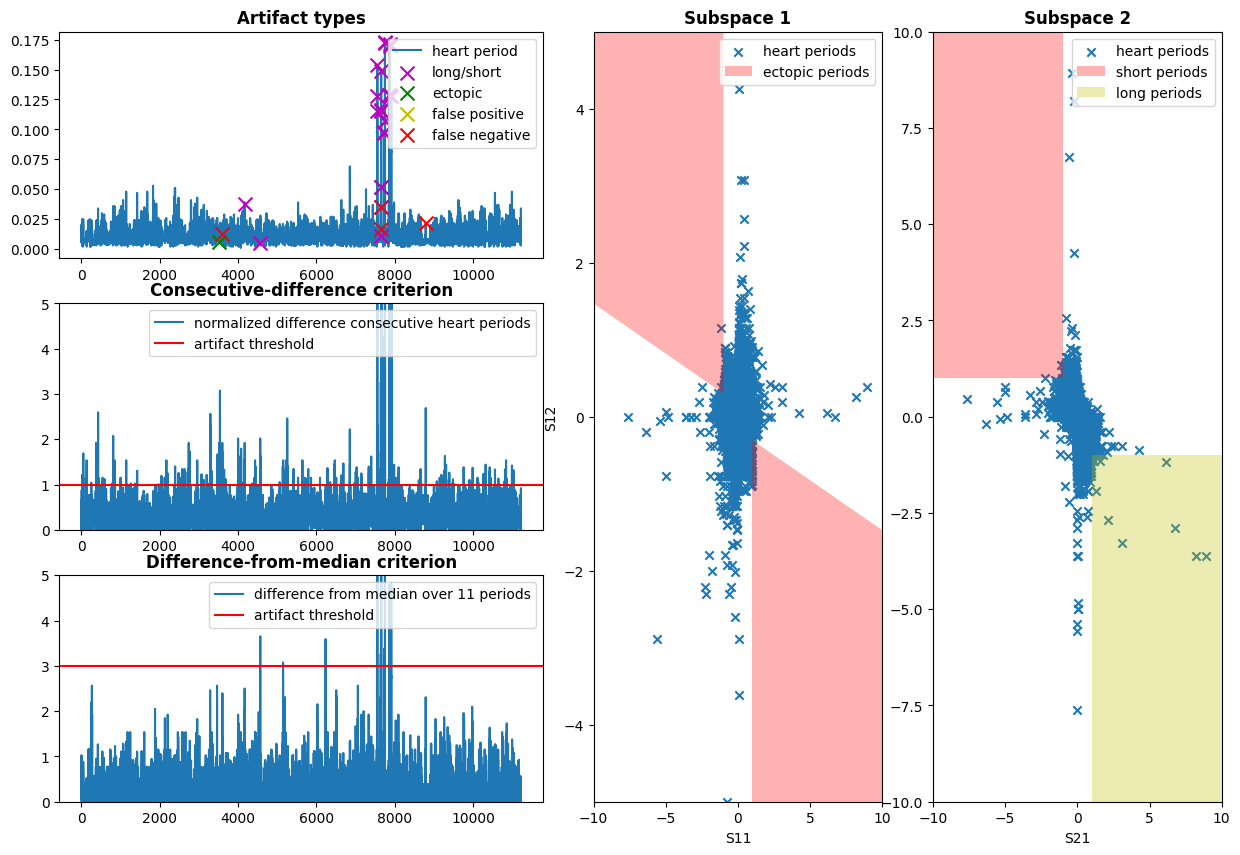

In [83]:
rpeaks_uncorrected  = nk.signal_findpeaks(Group1[0]['DATA'])
artifacts, rpeaks_corrected = nk.signal_fixpeaks(rpeaks_uncorrected, iterative=True, show=True)


c:\Users\Tom\.conda\envs\tfconda\Lib\site-packages\neurokit2\signal\signal_plot.py:175: FutureWarning: RangeIndex.is_integer is deprecated. Use pandas.api.types.is_integer_dtype instead.
  if sampling_rate is None and signal.index.is_integer():


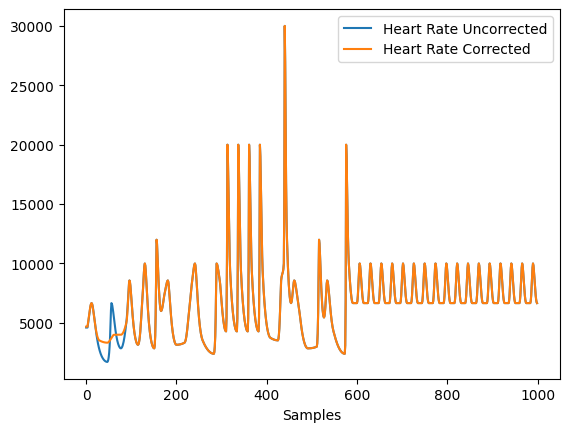

In [84]:
rate_corrected = nk.signal_rate(rpeaks_corrected, desired_length=len(Group1[0]['DATA']))

rate_uncorrected = nk.signal_rate(rpeaks_uncorrected, desired_length=len(Group1[0]['DATA']))

nk.signal_plot(
    [rate_uncorrected[:1000], rate_corrected[:1000]],
    labels=["Heart Rate Uncorrected", "Heart Rate Corrected"]
)

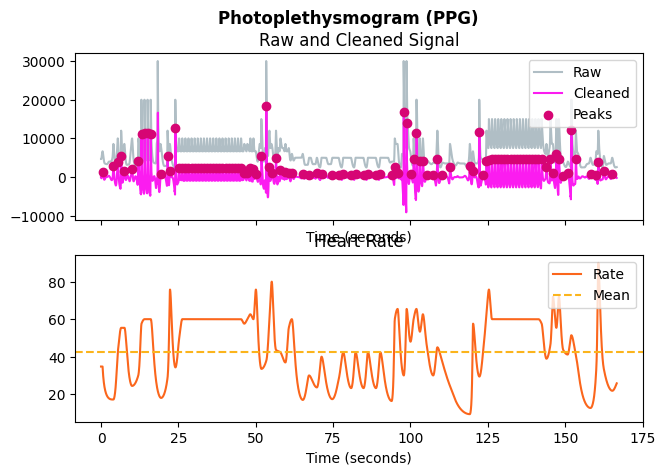

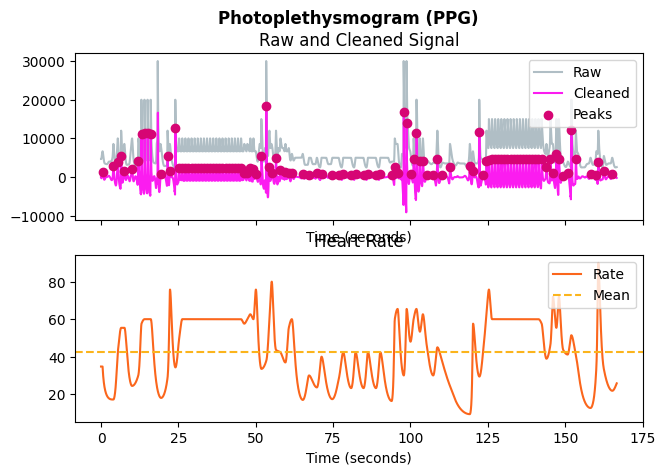

In [89]:
signals, info = nk.ppg_process(rate_corrected, sampling_rate=24)
nk.ppg_plot(signals[:4000], sampling_rate=24)

In [86]:
analyze_df = nk.ppg_analyze(signals, sampling_rate=sample_rate)
print(analyze_df)

   PPG_Rate_Mean   HRV_MeanNN     HRV_SDNN   HRV_SDANN1  HRV_SDNNI1  \
0      37.200808  1727.100154  2773.934585  1130.849059  2668.24222   

   HRV_SDANN2   HRV_SDNNI2  HRV_SDANN5   HRV_SDNNI5   HRV_RMSSD  ...  \
0   460.44691  2626.137474  343.242177  2676.152834  3805.40222  ...   

   HRV_SampEn  HRV_ShanEn  HRV_FuzzyEn  HRV_MSEn  HRV_CMSEn  HRV_RCMSEn  \
0    0.329139    4.702036     0.413515  0.290254   0.556601    0.450076   

     HRV_CD   HRV_HFD   HRV_KFD   HRV_LZC  
0  0.175638  1.950908  2.224295  0.701931  

[1 rows x 90 columns]


c:\Users\Tom\.conda\envs\tfconda\Lib\site-packages\neurokit2\ppg\ppg_intervalrelated.py:133: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  output[column] = float(results[column])


So it looks like the bad sections in the data are affecting the average calculations so now we will cut them out and do the analysis again

In [30]:
def cut_bad_data(raw, windowsize = 100):
    mx = np.max(raw)
    mn = np.min(raw)
    global_range = mx - mn
    
    filtered = []
    
    for i in range(len(raw) // windowsize):
        start = i * windowsize
        end = (i + 1) * windowsize
        sliced = raw[start:end]
        rng = np.max(sliced) - np.min(sliced)
        
        if ((rng >= (0.5 * global_range)) 
            or 
            (np.max(sliced) >= 0.9 * mx) 
            or 
            (np.min(sliced) <= mn + (0.1 * mn))):
            
            for x in sliced:
                filtered.append(np.nan)
        else:
            for x in sliced:
                filtered.append(x)
                
    filtered = np.array(filtered)
    filtered = filtered[~np.isnan(filtered)]
    return filtered

data = Group1[0]['DATA']
data = cut_bad_data(data)

c:\Users\Tom\.conda\envs\tfconda\Lib\site-packages\neurokit2\signal\signal_fixpeaks.py:277: RuntimeWarning: invalid value encountered in divide
  mrrs /= th2


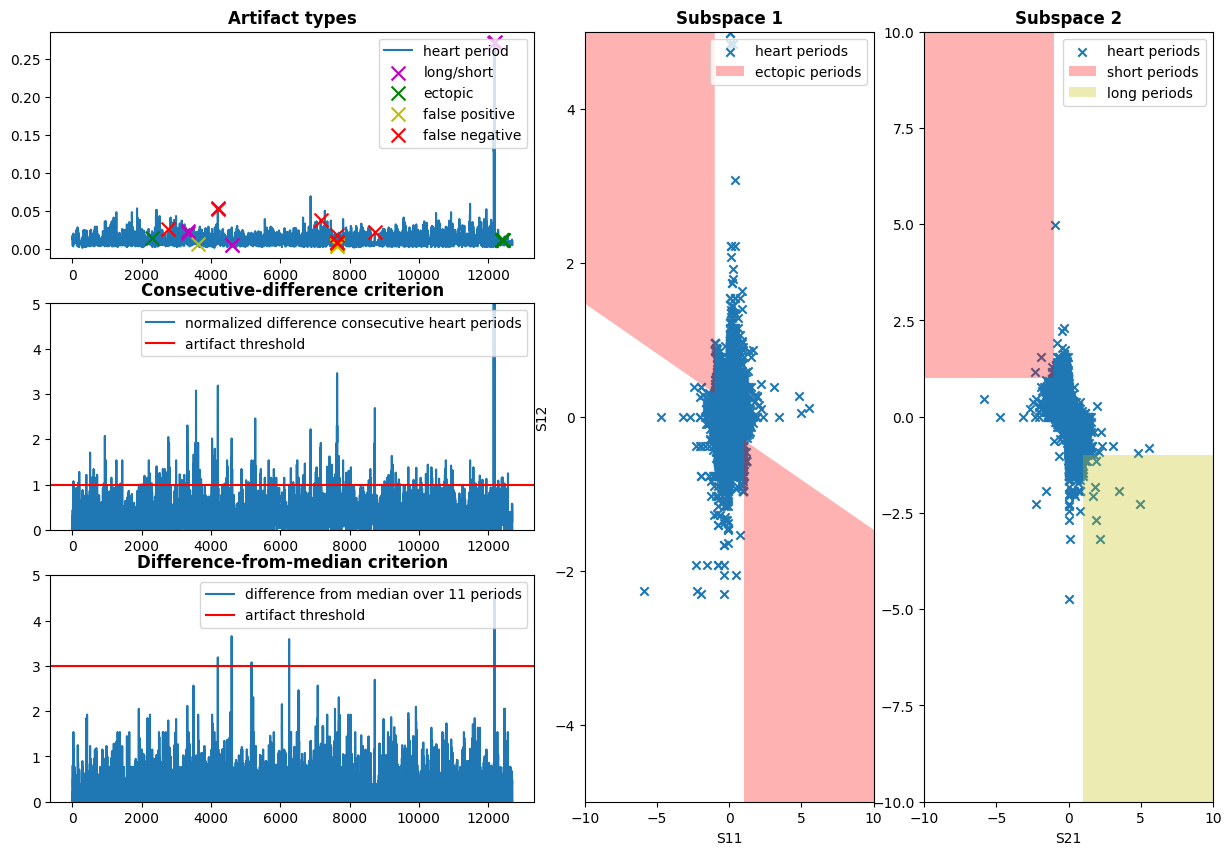

In [8]:
rpeaks_uncorrected  = nk.signal_findpeaks(data)
artifacts, rpeaks_corrected = nk.signal_fixpeaks(rpeaks_uncorrected, iterative=True, show=True)

c:\Users\Tom\.conda\envs\tfconda\Lib\site-packages\neurokit2\signal\signal_plot.py:175: FutureWarning: RangeIndex.is_integer is deprecated. Use pandas.api.types.is_integer_dtype instead.
  if sampling_rate is None and signal.index.is_integer():


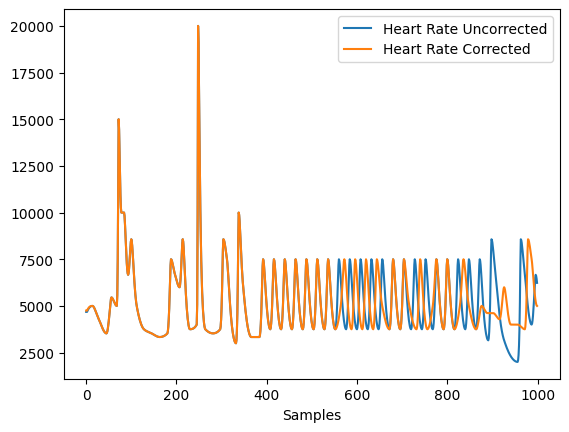

In [9]:
rate_corrected = nk.signal_rate(rpeaks_corrected, desired_length=len(Group1[0]['DATA']))

rate_uncorrected = nk.signal_rate(rpeaks_uncorrected, desired_length=len(Group1[0]['DATA']))

nk.signal_plot(
    [rate_uncorrected[:1000], rate_corrected[:1000]],
    labels=["Heart Rate Uncorrected", "Heart Rate Corrected"]
)

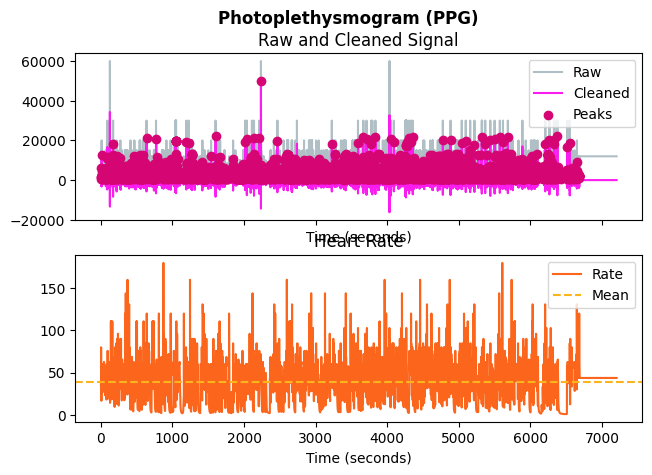

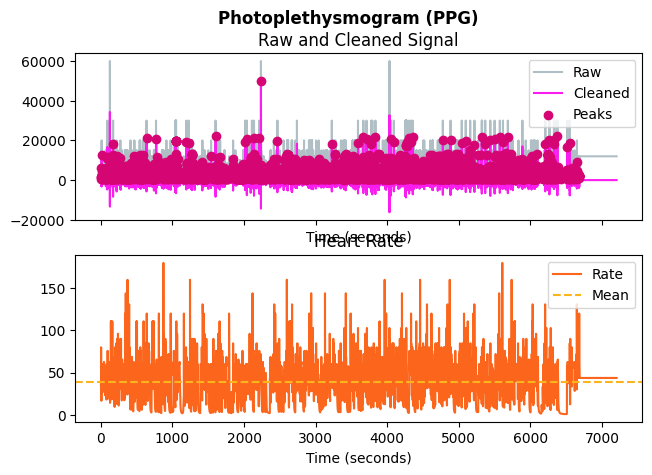

In [17]:
signals, info = nk.ppg_process(rate_corrected, sampling_rate=24)
nk.ppg_plot(signals, sampling_rate=24)

In [18]:
analyze_df = nk.ppg_analyze(signals, sampling_rate=24)
print(analyze_df)

c:\Users\Tom\.conda\envs\tfconda\Lib\site-packages\neurokit2\hrv\hrv_time.py:227: RuntimeWarning: Mean of empty slice
  avg_rri.append(np.nanmean(rri[start_idx:end_idx]))
c:\Users\Tom\.conda\envs\tfconda\Lib\site-packages\numpy\lib\nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


   PPG_Rate_Mean   HRV_MeanNN     HRV_SDNN   HRV_SDANN1  HRV_SDNNI1  \
0      38.244208  1686.642683  2930.107362  1160.148455  2505.21669   

   HRV_SDANN2   HRV_SDNNI2  HRV_SDANN5   HRV_SDNNI5    HRV_RMSSD  ...  \
0  494.735096  2549.140472  339.572395  2768.814295  3772.479911  ...   

   HRV_SampEn  HRV_ShanEn  HRV_FuzzyEn  HRV_MSEn  HRV_CMSEn  HRV_RCMSEn  \
0    0.298308    4.589013     0.378956  0.232152   0.502806    0.401979   

    HRV_CD   HRV_HFD   HRV_KFD   HRV_LZC  
0  0.12106  1.941402  1.926718  0.675882  

[1 rows x 90 columns]


c:\Users\Tom\.conda\envs\tfconda\Lib\site-packages\neurokit2\ppg\ppg_intervalrelated.py:133: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  output[column] = float(results[column])


Again not much changed. now I will try removing baseline wander, scaling and filtering along with the removal of bad sections 

In [31]:
import heartpy as hp

def remove_baseline_wander(data):
    data = hp.remove_baseline_wander(data, sample_rate=24)
    data = hp.filter_signal(data, cutoff=[0.7, 3.5], sample_rate=24, order=3, filtertype='bandpass')
    return data

data = cut_bad_data(Group1[0]['DATA'])
data = remove_baseline_wander(data)


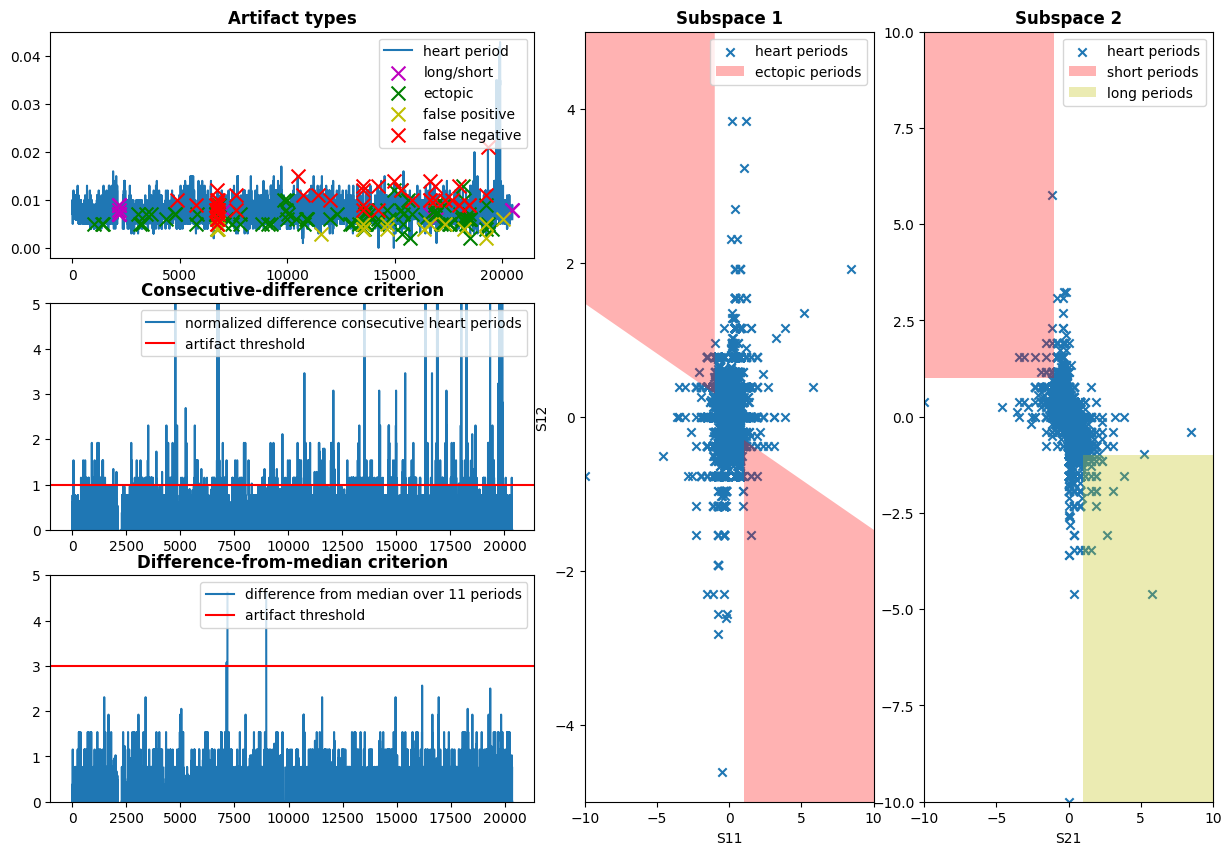

In [32]:
rpeaks_uncorrected  = nk.signal_findpeaks(data)
artifacts, rpeaks_corrected = nk.signal_fixpeaks(rpeaks_uncorrected, iterative=True, show=True)

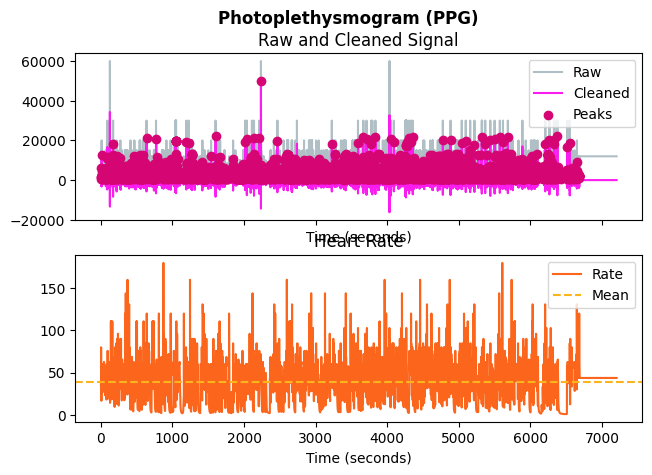

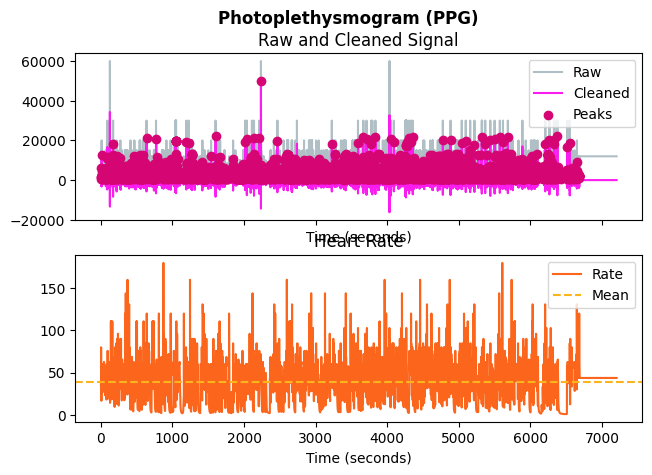

In [33]:
signals, info = nk.ppg_process(rate_corrected, sampling_rate=24)
nk.ppg_plot(signals, sampling_rate=24)

In [34]:
analyze_df = nk.ppg_analyze(signals, sampling_rate=24)
print(analyze_df)

c:\Users\Tom\.conda\envs\tfconda\Lib\site-packages\neurokit2\hrv\hrv_time.py:227: RuntimeWarning: Mean of empty slice
  avg_rri.append(np.nanmean(rri[start_idx:end_idx]))
c:\Users\Tom\.conda\envs\tfconda\Lib\site-packages\numpy\lib\nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


   PPG_Rate_Mean   HRV_MeanNN     HRV_SDNN   HRV_SDANN1  HRV_SDNNI1  \
0      38.244208  1686.642683  2930.107362  1160.148455  2505.21669   

   HRV_SDANN2   HRV_SDNNI2  HRV_SDANN5   HRV_SDNNI5    HRV_RMSSD  ...  \
0  494.735096  2549.140472  339.572395  2768.814295  3772.479911  ...   

   HRV_SampEn  HRV_ShanEn  HRV_FuzzyEn  HRV_MSEn  HRV_CMSEn  HRV_RCMSEn  \
0    0.298308    4.589013     0.378956  0.232152   0.502806    0.401979   

    HRV_CD   HRV_HFD   HRV_KFD   HRV_LZC  
0  0.12106  1.941402  1.926718  0.675882  

[1 rows x 90 columns]


c:\Users\Tom\.conda\envs\tfconda\Lib\site-packages\neurokit2\ppg\ppg_intervalrelated.py:133: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  output[column] = float(results[column])


Still not accurate. I will try using a different package for the ppg processing and see if that works

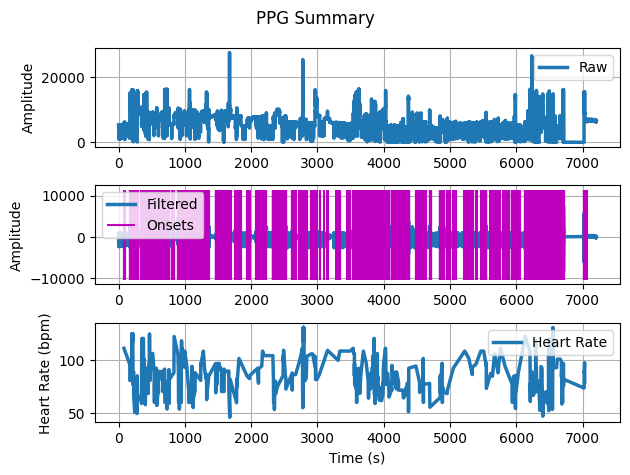

Median HR: 82.18623481781376 bpm


In [40]:
from biosppy.signals import ppg 
data = Group1[0]['DATA']
data = ppg.ppg(signal=data, sampling_rate=24.0, show=True)
median_hr = np.median(data[4])
print("Median HR: "+ str(median_hr) + " bpm")

In [43]:
data = data[1]

signals, info = nk.ppg_process(rate_corrected, sampling_rate=24)
nk.ppg_plot(signals, sampling_rate=24)

KeyError: 1

In [42]:
analyze_df = nk.ppg_analyze(signals, sampling_rate=24)
print(analyze_df)

   PPG_Rate_Mean  HRV_MeanNN     HRV_SDNN  HRV_SDANN1   HRV_SDNNI1  \
0      38.244208  843.321341  1465.053681  247.367548  1274.570236   

   HRV_SDANN2   HRV_SDNNI2  HRV_SDANN5   HRV_SDNNI5    HRV_RMSSD  ...  \
0  153.400122  1317.167642  116.617449  1392.736186  1886.239955  ...   

   HRV_SampEn  HRV_ShanEn  HRV_FuzzyEn  HRV_MSEn  HRV_CMSEn  HRV_RCMSEn  \
0    0.298308    4.589013     0.378956  0.232152   0.502806    0.401979   

     HRV_CD   HRV_HFD   HRV_KFD   HRV_LZC  
0  0.120962  1.941402  1.926718  0.675882  

[1 rows x 90 columns]


c:\Users\Tom\.conda\envs\tfconda\Lib\site-packages\neurokit2\ppg\ppg_intervalrelated.py:133: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  output[column] = float(results[column])


well thats not ideal... lets build our own process function based on biosppy sinmce it gives a realistic Median HR

In [46]:
def match_interpolate_hr(time,hr_time,hr):
    inter_hr = np.nan*np.ones(len(time)) # initialize interpolated hr array
    
    for i in range(len(hr_time)):
        i = hr_time[i]
        # find index of time that is closest in time to i
        idx = np.argmin(np.abs(time-i))
        inter_hr[idx] = hr[i]
    
    # interpolate missing values
    inter_hr = pd.Series(inter_hr)
    inter_hr = inter_hr.interpolate(method='linear')
    inter_hr = inter_hr.values


def custom_process(data, sample_rate=24):
    clean_data = ppg.ppg(signal=data, sampling_rate=sample_rate, show=False)
    
    raw = data.values
    clean_sig = clean_data[1]
    time = clean_data[0]
    
    
    
    heart_rate = clean_data[4]
    heart_rate_ts = clean_data[3]
    
    hr = match_interpolate_hr(time,heart_rate_ts,heart_rate)
    quality = nk.ecg_quality(clean_sig, sampling_rate=sample_rate)
    
    signals = pd.DataFrame({"ECG_Raw": raw,
                            "ECG_Clean": clean_sig,
                            "ECG_Rate": hr,
                            "ECG_Quality": quality})
    
    return signals


data = custom_process(Group1[0]['DATA'], sample_rate=24)


    
    

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices